In [119]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from tqdm import tqdm
from datetime import datetime

In [120]:
# Reading the csv into data frame
df = pd.read_csv('zrx.csv')

In [121]:
# df.head()

In [122]:
# Note: All the columns are of dtype object, need to convert them accordingly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176713 entries, 0 to 2176712
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   from_address  object
 2   to_address    object
 3   value         object
dtypes: object(4)
memory usage: 66.4+ MB


In [123]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

In [124]:
# Convert value to float and to exact token value
df['value'] = df['value'].astype(float)
df['value'] = df['value'] / 10**18

In [125]:
# Descriptive statistics about value
df[['value']].describe()

,value
count,2.176713e+06
mean,1.360421e+04
std,5.635274e+05
min,0.000000e+00
25%,1.255157e+02
50%,9.947627e+02
75%,6.811867e+03
max,5.000000e+08


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176713 entries, 0 to 2176712
Data columns (total 4 columns):
 #   Column        Dtype              
---  ------        -----              
 0   date          datetime64[ns, UTC]
 1   from_address  object             
 2   to_address    object             
 3   value         float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 66.4+ MB


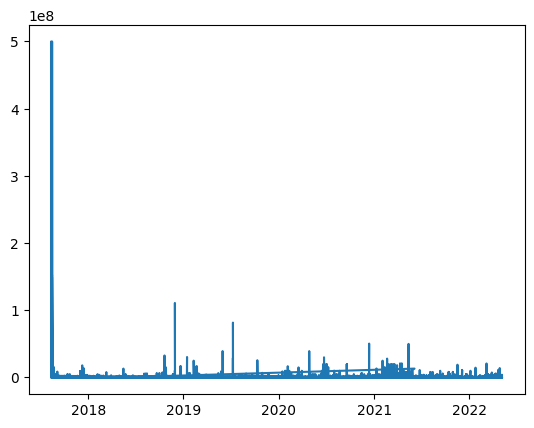

In [127]:
# Observe the straight line in the plot which shows date are not in sorted order
# In order to keep track of everyday balance, the transactions should be in sorted order 
plt.plot(df['date'], df['value'])
plt.show()

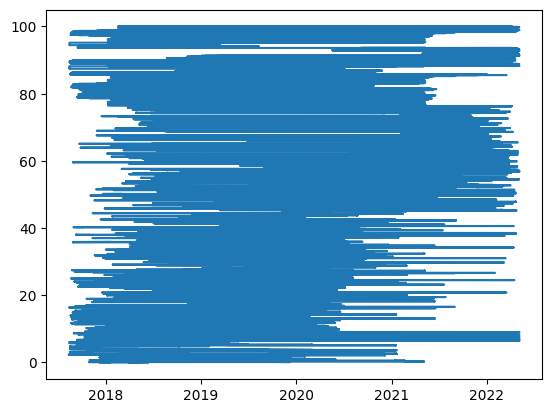

In [128]:
# Demonstrate the issue with the plot, it's just not one date mismatch
# The line should be a continuous curve
plt.plot(df['date'].values, np.linspace(0, 100, len(df)))
plt.show()

In [129]:
# Sorted data frame by date
df.sort_values(by='date', ignore_index=True, inplace=True)

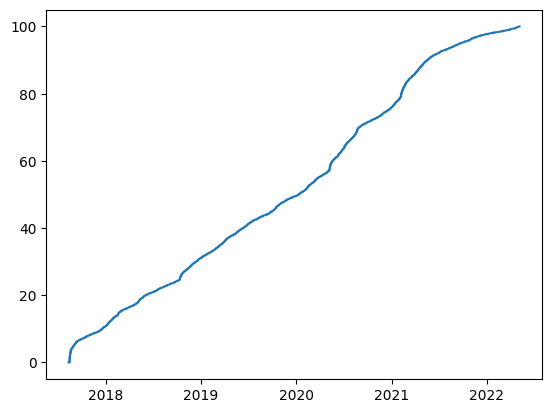

In [130]:
plt.plot(df['date'].values, np.linspace(0, 100, len(df)))
plt.show()

In [80]:
# Note: Multiple transactions at a single point of time
df['date'].value_counts()

date
2021-06-05 13:40:21+00:00    376
2020-01-28 11:18:25+00:00    305
2021-09-26 14:10:29+00:00    296
2019-07-21 18:06:45+00:00    295
2021-06-13 05:46:43+00:00    295
                            ... 
2019-05-24 04:42:44+00:00      1
2019-05-24 04:41:05+00:00      1
2019-05-24 04:39:06+00:00      1
2019-05-24 04:37:23+00:00      1
2022-05-05 23:58:31+00:00      1
Name: count, Length: 1497871, dtype: int64

In [134]:
# Taking out the date only from the date column
df['day'] = [datetime.strftime(d, '%Y-%m-%d') for d in df['date']]
df.drop('date', axis=1, inplace=True)

In [138]:
df = df[['day','from_address', 'to_address', 'value']]

In [146]:
df['day'].value_counts()

day
2017-08-15    22670
2017-08-16    21019
2018-10-12    15397
2017-08-19    14077
2021-02-05    12521
              ...  
2022-01-30      218
2022-01-14      216
2017-08-11       13
2017-08-13        8
2017-08-14        2
Name: count, Length: 1728, dtype: int64

In [ ]:
# All the accounts involved in transaction

In [43]:
from_address = list(set(df['from_address']))
to_address = list(set(df['to_address']))
all_address = list(set(df['from_address']).union(set(df['to_address'])))

In [48]:
# Initialize the balance to 0
balanceDict = {}
for i in all_address:
    balanceDict[i] = {}